`1` Takes (pickup signals, coil currents, p-profile) --> poloidal flux map --> Classification of limiter or diverted and identification of LCFS


In [1]:
!hostname
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('CPU')))

mfews-arunavk


2025-03-17 11:03:59.844995: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  1


In [3]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"   
import random

import numpy as np
import pandas as pd
from numpy import matlib as mb
import matplotlib.pyplot as plt
import scipy.io

import seaborn as sns
sns.set_style("darkgrid")

import random
import matplotlib.lines as mlines

from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

print("TensorFlow version: ", tf.__version__)

from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.metrics import (r2_score, f1_score, accuracy_score, 
                             roc_curve, roc_auc_score, mean_squared_error)

import scipy.interpolate as interp
from scipy import interpolate, signal
import scipy.ndimage
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
#import mat73


TensorFlow version:  2.6.2


In [4]:
filename='../../ARC_like_equilibrium_dataset.mat'
mat = scipy.io.loadmat(filename)
...
for key,val in mat.items():
    print(key)
    exec(key + '=val')

__header__
__version__
__globals__
DB_meas_Bpickup_test_ConvNet
DB_psi_pixel_test_ConvNet
DB_res_RHS_pixel_test_ConvNet
DB_Jpla_pixel_test_ConvNet
DB_coils_curr_test_ConvNet
RR_pixels
ZZ_pixels
DB_separatrix_200_test_ConvNet
XP_YN
DB_f_test_ConvNet
DB_p_test_ConvNet


In [5]:
DTYPE = 'float32'

DB_meas_Bpickup_test_ConvNet = mat['DB_meas_Bpickup_test_ConvNet'].astype(DTYPE)
DB_coils_curr_test_ConvNet   = mat['DB_coils_curr_test_ConvNet'].astype(DTYPE)
DB_p_test_ConvNet            = mat['DB_p_test_ConvNet'].astype(DTYPE)
res_RHS_pixel_data_load      = mat['DB_res_RHS_pixel_test_ConvNet'].astype(DTYPE)

RR_pixels                    = mat['RR_pixels'].astype(DTYPE)
ZZ_pixels                    = mat['ZZ_pixels'].astype(DTYPE)

DB_res_RHS_pixel_test_ConvNet   = mat['DB_res_RHS_pixel_test_ConvNet'].astype(DTYPE)
DB_separatrix_200_test_ConvNet  = mat['DB_separatrix_200_test_ConvNet'].astype(DTYPE)
XP_YN                           = mat["XP_YN"]                    # optional (diverted vs limiter)

DB_psi_pixel_test_ConvNet    = mat['DB_psi_pixel_test_ConvNet'].astype(DTYPE)
DB_Jpla_pixel_test_ConvNet   = mat['DB_Jpla_pixel_test_ConvNet'].astype(DTYPE)

print("DB_meas_Bpickup_test_ConvNet shape:", DB_meas_Bpickup_test_ConvNet.shape)
print("DB_coils_curr_test_ConvNet shape:   ", DB_coils_curr_test_ConvNet.shape)
print("DB_p_test_ConvNet shape:            ", DB_p_test_ConvNet.shape)
print("DB_psi_pixel_test_ConvNet shape:    ", DB_psi_pixel_test_ConvNet.shape)
print("RR_pixels shape:                    ", RR_pixels.shape)
print("ZZ_pixels shape:                    ", ZZ_pixels.shape)
print("XP_YN shape:                        ", XP_YN.shape)
print("DB_separatrix_200_test_ConvNet shape:", DB_separatrix_200_test_ConvNet.shape)
print("res_RHS_pixel_data_load shape:      ", res_RHS_pixel_data_load.shape)

DB_meas_Bpickup_test_ConvNet shape: (81986, 187)
DB_coils_curr_test_ConvNet shape:    (81986, 14)
DB_p_test_ConvNet shape:             (81986, 101)
DB_psi_pixel_test_ConvNet shape:     (81986, 64, 64)
RR_pixels shape:                     (64, 64)
ZZ_pixels shape:                     (64, 64)
XP_YN shape:                         (1, 81986)
DB_separatrix_200_test_ConvNet shape: (81986, 200, 2)
res_RHS_pixel_data_load shape:       (81986, 64, 64)


81013


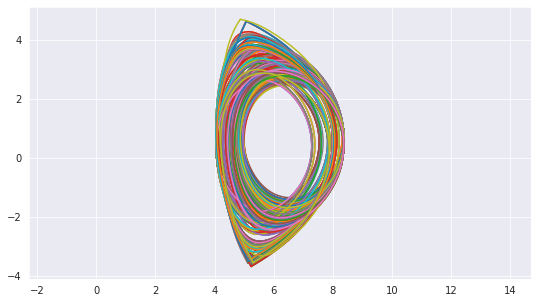

In [6]:
plt.figure(figsize=(9, 5))
ind_plot = np.random.randint(0,DB_Jpla_pixel_test_ConvNet.shape[0],1)[0]
print(ind_plot)
for i in range(1,1000):
    plt.plot(DB_separatrix_200_test_ConvNet[i,:,0],DB_separatrix_200_test_ConvNet[i,:,1])
    plt.axis('equal')
plt.show()

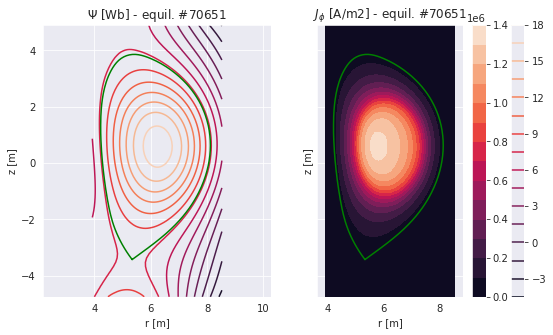

In [7]:
for i in range(0,1):
    ind_plot = np.random.randint(0,DB_Jpla_pixel_test_ConvNet.shape[0],1)[0]
    fig, axs = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
    img = axs[0].contour(RR_pixels,ZZ_pixels,DB_psi_pixel_test_ConvNet[ind_plot,:,:],15)
    fig.colorbar(img)
    axs[0].plot(
        DB_separatrix_200_test_ConvNet[ind_plot,:,0],
        DB_separatrix_200_test_ConvNet[ind_plot,:,1],
        c='g')
    axs[0].axis('equal')
    axs[0].set_xlabel('r [m]')
    axs[0].set_ylabel('z [m]')
    axs[0].set_title('$\Psi$ [Wb] - equil. #{}'.format(ind_plot))
    img = axs[1].contourf(RR_pixels,ZZ_pixels,DB_Jpla_pixel_test_ConvNet[ind_plot,:,:],15)
    fig.colorbar(img)
    axs[1].axis('equal')
    axs[1].set_title('$J_\phi$ [A/m2] - equil. #{}'.format(ind_plot))
    axs[1].set_xlabel('r [m]')
    axs[1].set_ylabel('z [m]')
    axs[1].plot(
        DB_separatrix_200_test_ConvNet[ind_plot,:,0],
        DB_separatrix_200_test_ConvNet[ind_plot,:,1],
        c='g')




In [8]:
#[B_pickup signals, coil currents, p-profile]
X_data = np.column_stack([
    DB_meas_Bpickup_test_ConvNet,
    DB_coils_curr_test_ConvNet,
    DB_p_test_ConvNet
])

# The target: 2D poloidal flux map for each sample
y_data = DB_psi_pixel_test_ConvNet  # shape: (num_samples, nR, nZ)

In [9]:
num_samples = X_data.shape[0]
indices = np.arange(num_samples)

id_train, id_test = train_test_split(indices, test_size=0.3, random_state=42)

X_train = X_data[id_train, :]
X_test  = X_data[id_test, :]

y_train = y_data[id_train, :, :]
y_test  = y_data[id_test, :, :]


In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [11]:
n_r = y_train.shape[1]  # number of radial points
n_z = y_train.shape[2]  # number of vertical points
out_size = n_r * n_z    # flatten the 2D flux map

def build_dense_model(input_dim, output_dim):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='linear')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_dense_model(input_dim=X_train.shape[1], output_dim=out_size)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 302)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               38784     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              528384    
Total params: 600,192
Trainable params: 600,192
Non-trainable params: 0
_________________________________________________________________


In [12]:
y_train_flat = y_train.reshape(y_train.shape[0], -1)  # shape: (N, nR*nZ)
y_test_flat  = y_test.reshape(y_test.shape[0], -1)

history = model.fit(X_train, y_train_flat,
                    validation_data=(X_test, y_test_flat),
                    epochs=50, batch_size=32, verbose=1)

Epoch 1/50
1794/1794 [==============================] - 14s 6ms/step - loss: 1.6118 - val_loss: 0.0986
Epoch 2/50
1794/1794 [==============================] - 10s 5ms/step - loss: 0.0970 - val_loss: 0.0583
Epoch 3/50
1794/1794 [==============================] - 10s 5ms/step - loss: 0.0647 - val_loss: 0.0396
Epoch 4/50
1794/1794 [==============================] - 10s 5ms/step - loss: 0.0463 - val_loss: 0.0390
Epoch 5/50
1794/1794 [==============================] - 10s 5ms/step - loss: 0.0476 - val_loss: 0.0300
Epoch 6/50
1794/1794 [==============================] - 10s 5ms/step - loss: 0.0424 - val_loss: 0.0161
Epoch 7/50
1794/1794 [==============================] - 9s 5ms/step - loss: 0.0432 - val_loss: 0.0139
Epoch 8/50
1794/1794 [==============================] - 9s 5ms/step - loss: 0.0211 - val_loss: 0.0270
Epoch 9/50
1794/1794 [==============================] - 10s 6ms/step - loss: 0.0284 - val_loss: 0.0860
Epoch 10/50
1794/1794 [==============================] - 10s 6ms/step - los

In [13]:
y_pred_train_flat = model.predict(X_train)
y_pred_test_flat  = model.predict(X_test)

y_pred_train = y_pred_train_flat.reshape(-1, n_r, n_z)# Reshape back to 2D flux
y_pred_test  = y_pred_test_flat.reshape(-1, n_r, n_z)

In [14]:
r2_train = r2_score(y_train_flat, y_pred_train_flat)
r2_test  = r2_score(y_test_flat,  y_pred_test_flat)
mse_train = mean_squared_error(y_train_flat, y_pred_train_flat)
mse_test  = mean_squared_error(y_test_flat,  y_pred_test_flat)

print(f"R² train={r2_train:.4f}, test={r2_test:.4f}")
print(f"MSE train={mse_train:.6e}, test={mse_test:.6e}")


R² train=0.9999, test=0.9999
MSE train=2.903390e-03, test=2.887606e-03


(3.924999952316284, 8.524999618530273, -4.75, 4.900000095367432)

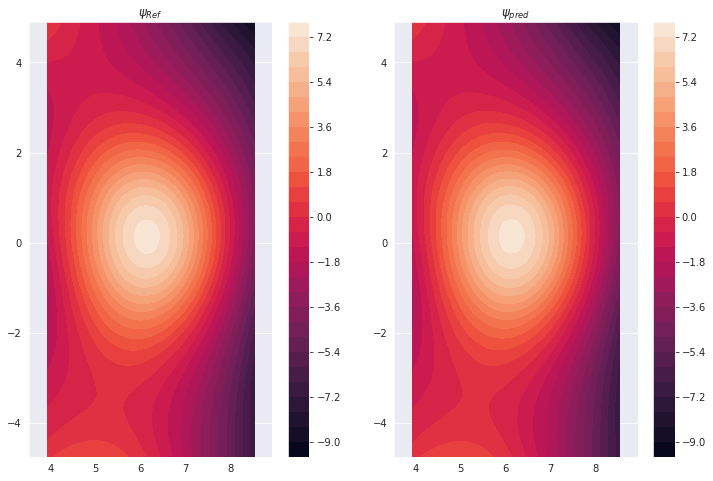

In [15]:
import random
idx = random.randint(0, len(id_test)-1)

psi_ref = y_test[idx,:,:]
psi_pred = y_pred_test[idx,:,:]

plt.figure(figsize=(12,8))
#plt.suptitle(f"Sample index {idx} (Test)")
plt.subplot(1,2,1)
plt.title("$\psi_{Ref}$")
plt.contourf(RR_pixels, ZZ_pixels, psi_ref, 30)
plt.colorbar()
plt.axis('equal')
plt.subplot(1,2,2)
plt.title("$\psi_{pred}$")
plt.contourf(RR_pixels, ZZ_pixels, psi_pred, 30)
plt.colorbar()
plt.axis('equal')

In [ ]:
N, nR, nZ = DB_psi_pixel_test_ConvNet.shape
flux_flat = DB_psi_pixel_test_ConvNet.reshape(N, -1)  # shape: (N, nR*nZ)
XP_YN.shape

In [ ]:
y_class = XP_YN.squeeze().astype(np.float32)  # shape: (N,)
y_class.shape

In [ ]:
N_bound_pts = DB_separatrix_200_test_ConvNet.shape[1]  # 200
y_boundary = DB_separatrix_200_test_ConvNet.reshape(N, -1).astype(np.float32)  # shape: (N, 400)

yindices = np.arange(N)
id_train, id_test = train_test_split(yindices, test_size=0.3, random_state=42)
id_test.shape

In [ ]:
X_train = flux_flat[id_train, :]  # shape: (N_train, nR*nZ)
X_test  = flux_flat[id_test, :]
y_class_train = y_class[id_train]         # shape: (N_train,)
y_class_test  = y_class[id_test]
y_bound_train = y_boundary[id_train, :]   # shape: (N_train, 400)
y_bound_test  = y_boundary[id_test, :]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
def build_multi_output_model(n_input, n_boundary):
    """
    n_input: size of flattened flux (nR*nZ)
    n_boundary: total boundary coords to predict (200*2 = 400)
    """
    inputs = layers.Input(shape=(n_input,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    clas_out = layers.Dense(1, activation='sigmoid', name="classification_head")(x)
    bound_out = layers.Dense(n_boundary, activation='linear', name="boundary_head")(x)
    model = Model(inputs=inputs, outputs=[clas_out, bound_out])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={
            "classification_head": "binary_crossentropy",
            "boundary_head": "mse"
        },
        metrics={
            "classification_head": ["accuracy"]
        }
    )

    return model
n_input = X_train_scaled.shape[1]  # nR*nZ
n_boundary = y_bound_train.shape[1]  # 400
model_multi = build_multi_output_model(n_input, n_boundary)
model_multi.summary()


## Defining Loss Function
* Loss= $\alpha_{1} \|\psi_{pred} − \psi_{ref}\|^{2} + \alpha_{2} \|\Delta^{*}\psi_{pred} − \Delta^{*}\psi_{ref}\|^2$


In [ ]:
history_cl = model_multi.fit(
    X_train_scaled,
    [y_class_train, y_bound_train],
    validation_data=(
        X_test_scaled,
        [y_class_test, y_bound_test]
    ),
    epochs=50,
    batch_size=32,
    verbose=1
)
y_class_pred_train, y_bound_pred_train = model_multi.predict(X_train_scaled)
y_class_pred_test,  y_bound_pred_test  = model_multi.predict(X_test_scaled)
y_class_bin_train = (y_class_pred_train > 0.5).astype(int).ravel()
y_class_bin_test  = (y_class_pred_test  > 0.5).astype(int).ravel()
acc_train = accuracy_score(y_class_train, y_class_bin_train)
acc_test  = accuracy_score(y_class_test,  y_class_bin_test)

f1_train  = f1_score(y_class_train, y_class_bin_train)
f1_test   = f1_score(y_class_test,  y_class_bin_test)

print(f"Classification - TRAIN: Acc={acc_train:.3f}, F1={f1_train:.3f}")
print(f"Classification - TEST:  Acc={acc_test:.3f},  F1={f1_test:.3f}")

In [ ]:
y_bound_train_flat = y_bound_train.reshape(-1)
y_bound_pred_train_flat = y_bound_pred_train.reshape(-1)

r2_bound_train = r2_score(y_bound_train_flat, y_bound_pred_train_flat)

y_bound_test_flat = y_bound_test.reshape(-1)
y_bound_pred_test_flat = y_bound_pred_test.reshape(-1)
r2_bound_test  = r2_score(y_bound_test_flat, y_bound_pred_test_flat)
print(f"Boundary R² - TRAIN: {r2_bound_train:.4f}, TEST: {r2_bound_test:.4f}")


In [ ]:
for _ in range(3):
    idx = random.randint(0, len(id_test)-1)
    true_label = y_class_test[idx]
    pred_prob  = y_class_pred_test[idx][0]
    pred_label = y_class_bin_test[idx]

    print(f"Sample {idx}: True label={true_label} / Pred prob={pred_prob:.3f} / Pred label={pred_label}")

idx = random.randint(0, len(id_test)-1)
bound_true = y_bound_test[idx,:].reshape(-1,2)
bound_pred = y_bound_pred_test[idx,:].reshape(-1,2)

plt.figure(figsize=(10,8))
psi_2d = DB_psi_pixel_test_ConvNet[id_test[idx], :, :]
plt.contour(RR_pixels, ZZ_pixels, psi_2d, 40)
plt.colorbar(label="Poloidal Flux")
plt.plot(bound_true[:,0], bound_true[:,1], 'b--', label="True LCFS")
plt.plot(bound_pred[:,0], bound_pred[:,1], 'g-', markersize=2, label="Pred LCFS")
plt.legend(fontsize=18)
plt.axis('equal')
plt.show()

In [ ]:
DB_meas_Bpickup_test_ConvNet[0,:].shape

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss vs epochs
plt.figure(figsize=(8, 5))
plt.semilogy(train_loss, label='Training Loss')
plt.semilogy(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def compute_GS_operator(psi, RR, ZZ):
    """
    psi shape: (batch, nR, nZ)
    RR, ZZ shape: (nR, nZ) - same for all batch
    Returns: gs_op shape (batch, nR, nZ)
    """
    # naive center-diff. ignoring edges
    # We'll do it in numpy for clarity; for a TF-based approach, we could use tf.nn.conv2d
    
    # We assume psi, RR, ZZ are np arrays for the moment (custom loop).
    # If you want it purely in TF, you'll define a tf function using convolutions.
    
    batch_size = psi.shape[0]
    nR, nZ = psi.shape[1], psi.shape[2]
    gs_op = np.zeros_like(psi)
    
    dR = RR[1,0] - RR[0,0]
    dZ = ZZ[0,1] - ZZ[0,0] if nZ>1 else 1e-3  # you must adapt if your grid is different

    for b in range(batch_size):
        psi_b = psi[b,:,:]
        # Laplacian
        lap = (
            np.roll(psi_b, 1, axis=0) - 2*psi_b + np.roll(psi_b, -1, axis=0)
        )/(dR**2) + (
            np.roll(psi_b, 1, axis=1) - 2*psi_b + np.roll(psi_b, -1, axis=1)
        )/(dZ**2)

        # - (1/R)* d(psi)/dR
        # R is function of row index => R[i,:]
        R_1d = RR[:,0]  # shape (nR,)
        dpsi_dR = (
            np.roll(psi_b, -1, axis=0) - np.roll(psi_b, 1, axis=0)
        )/(2*dR)
        
        # broadcast R to shape (nR, nZ)
        R_2d = np.tile(R_1d.reshape(-1,1), (1,nZ))
        out = lap - (1.0/R_2d)*dpsi_dR
        gs_op[b,:,:] = out

    return gs_op
